In [1]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install face_recognition

In [21]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [7]:
import glob

celeb_df_fake = glob.glob('/content/drive/My Drive/Face_only_data/Celeb_fake_face_only/*.mp4')
celeb_df_real = glob.glob('/content/drive/My Drive/Face_only_data/Celeb_real_face_only/*.mp4')
kaggle_fake = glob.glob('/content/drive/My Drive/Face_only_data/DFDC_FAKE_Face_only_data/*.mp4')
kaggle_real = glob.glob('/content/drive/My Drive/Face_only_data/DFDC_REAL_Face_only_data/*.mp4')
ff_forensic = glob.glob('/content/drive/My Drive/Face_only_data/FF_Face_only_data/*.mp4')

video_files = celeb_df_fake + celeb_df_real + kaggle_fake + kaggle_real + ff_forensic

In [9]:
# import json
# import glob
# import numpy as np
# import cv2
# import copy
# import random

# random.shuffle(video_files)
# valid_videos = []
# frames = []
# for video_file in video_files:
#     cap = cv2.VideoCapture(video_file)
#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     if frame_count >= 100:
#         valid_videos.append(video_file)
#         frames.append(frame_count)
# print("frames are " , frames)
# print("Total no of frame: " , len(frames))
# print('Average frame per video:',np.mean(frames))

In [ ]:
# import torch
# import torchvision
# from torchvision import transforms
# from torch.utils.data import DataLoader
# import os
# import numpy as np
# import cv2
# import logging
# import face_recognition

# # video_files = glob.glob('/content/drive/My Drive/Face_only_data/*/*.mp4')




# print("Total number of videos: ", len(video_files))


# # Validate the video and transform frames
# def validate_video(vid_path,train_transforms):
#       transform = train_transforms
#       count = 20
#       video_path = vid_path
#       frames = []
#       a = int(100/count)
#       first_frame = np.random.randint(0,a)
#       temp_video = video_path.split('/')[-1]
#       for i,frame in enumerate(frame_extract(video_path)):
#         frames.append(transform(frame))
#         if(len(frames) == count):
#           break
#       frames = torch.stack(frames)
#       frames = frames[:count]
#       return frames
# #extract a from from video
# def frame_extract(path):
#   vidObj = cv2.VideoCapture(path)
#   success = 1
#   while success:
#       success, image = vidObj.read()
#       if success:
#           yield image

# im_size = 112
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# train_transforms = transforms.Compose([
#                                         transforms.ToPILImage(),
#                                         transforms.Resize((im_size,im_size)),
#                                         transforms.ToTensor(),
#                                         transforms.Normalize(mean,std)])

# # print(video_files)
# count = 0
# for i in video_files:
#   try:
#     count+=1
#     validate_video(i,train_transforms)
#   except:
#     print("Number of video processed: " , count ," Remaining : " , (len(video_files) - count))
#     print("Corrupted video is : " , i)
#     continue
# print((len(video_files) - count))

In [10]:
random.shuffle(video_files)

In [11]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None ,im_size = 112 ):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
        self.im_size = im_size  # Add im_size as an attribute


    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
            image = cv2.resize(image, (self.im_size, self.im_size))  # Ensure uniform size
            yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()




In [14]:
#count the number of fake and real videos
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/Face_only_data/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake


train :  5159
test :  1290
TRAIN:  Real: 2652  Fake: 2507


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


TEST:  Real: 656  Fake: 634


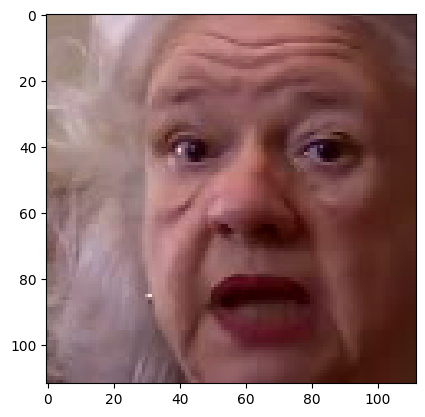

In [23]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/Face_only_data/Gobal_metadata.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 10,transform = train_transforms)

def custom_collate_fn(batch):
    frames, labels = zip(*batch)
    min_seq_len = min([f.size(0) for f in frames])
    frames = [f[:min_seq_len] for f in frames]
    frames = torch.stack(frames)
    labels = torch.tensor(labels)
    return frames, labels

train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4, collate_fn=custom_collate_fn)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4 , collate_fn=custom_collate_fn)
image,label = train_data[0]
im_plot(image[0,:,:,:])


In [24]:
#Model with feature visualization
from torch import nn
from torchvision import models
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        # Load pre-trained weights from ImageNet
        weights = ResNeXt50_32X4D_Weights.IMAGENET1K_V1
        model = resnext50_32x4d(weights=weights)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))


model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))


In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size


In [26]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg

In [27]:
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

In [28]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

[Epoch 1/20] [Batch 1289 / 1290] [Loss: 0.641290, Acc: 63.64%]Testing
[Batch 322 / 323]  [Loss: 0.523012, Acc: 75.19%]
Accuracy 75.1937984496124
[Epoch 2/20] [Batch 1289 / 1290] [Loss: 0.542939, Acc: 75.96%]Testing
[Batch 322 / 323]  [Loss: 0.434425, Acc: 80.85%]
Accuracy 80.85271317829458
[Epoch 3/20] [Batch 1289 / 1290] [Loss: 0.487300, Acc: 80.36%]Testing
[Batch 322 / 323]  [Loss: 0.430685, Acc: 79.22%]
Accuracy 79.2248062015504
[Epoch 4/20] [Batch 1289 / 1290] [Loss: 0.444349, Acc: 82.81%]Testing
[Batch 322 / 323]  [Loss: 0.403227, Acc: 81.40%]
Accuracy 81.3953488372093
[Epoch 5/20] [Batch 1289 / 1290] [Loss: 0.405691, Acc: 86.02%]Testing
[Batch 322 / 323]  [Loss: 0.426515, Acc: 81.01%]
Accuracy 81.0077519379845
[Epoch 6/20] [Batch 1289 / 1290] [Loss: 0.389846, Acc: 87.23%]Testing
[Batch 322 / 323]  [Loss: 0.410369, Acc: 82.33%]
Accuracy 82.32558139534883
[Epoch 7/20] [Batch 1289 / 1290] [Loss: 0.335685, Acc: 89.77%]Testing
[Batch 322 / 323]  [Loss: 0.502427, Acc: 79.61%]
Accuracy 

20


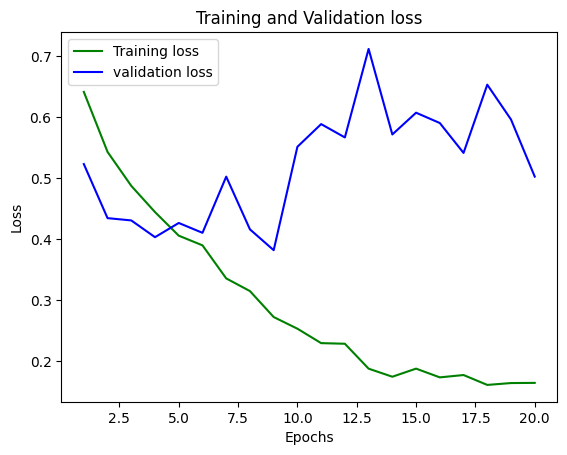

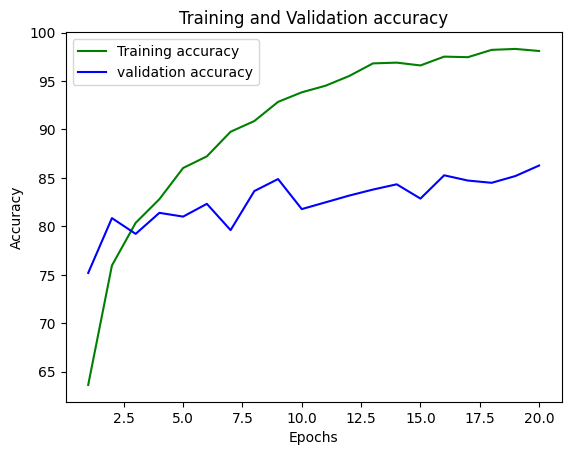

[[539  95]
 [ 82 574]]
True positive =  539
False positive =  95
False negative =  82
True negative =  574




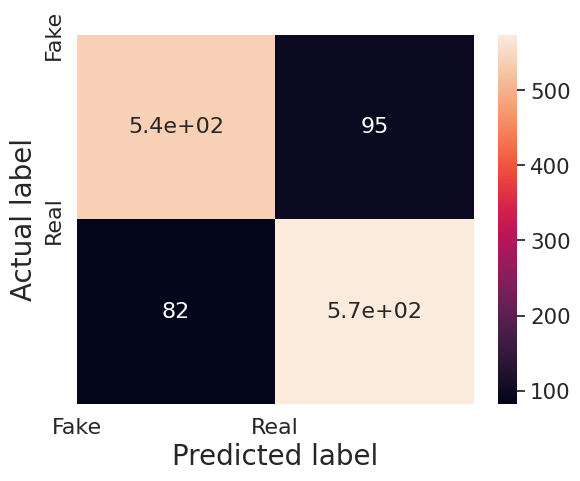

Calculated Accuracy 86.27906976744187


In [29]:
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)
